# Classification using Gaussian Mixture Models

In [1]:
import numpy as np
import librosa
import scipy as sp
%matplotlib inline

import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.mixture import BayesianGaussianMixture
import scipy.stats
import seaborn as sns

# Feature definition

### *Exercise 1*: Zero crossing rate

Define a function that compute **zero crossing rate** for a window. Remember that the definition of zero crossing rate is:

$$ ZCR = \frac{1}{2N} Fs \sum_{t=1}^{N-1} | sign(t) - sign(t-1)|  $$

**Hints**:

- the function takes as input a window of the signal and the sampling frequency
- check the function ```np.sign``` from Numpy




In [2]:
def compute_zcr(win, Fs):
    win_sign = np.sign(win)
    
    N = win.shape[0]
        
    sign_diff = np.abs(win_sign[:-1] - win_sign[1:])
    
    zcr = len(sign_diff[sign_diff != 0]) * Fs / N 
    
    # equivalent to
    
    zcr2 = np.sum(sign_diff) * Fs / (2 * N)
    return zcr

### *Exercise 2* : Spectral centroid

Define a function that compute **spectral centroid** for a window. Remember that the definition of spectral centroid is:

$$ C = \frac{\sum_{k=0}^{K/2 -1} f_k |S(k)|}{\sum_{k=0}^{K/2 - 1} |S(k)|} $$

**Hints**:

- the function takes as input the spectrum computed on a window of the signal
- use arrays and operate on them , using for example ``` np.sum ``` from Numpy 

In [3]:
def compute_speccentr(spec, Fs):
    freq_axis = np.linspace(0, Fs // 2, len(spec))
    centr = np.dot(freq_axis, np.abs(spec)) / np.sum(np.abs(spec), axis = 0)
    return centr

### *Exercise 3*: Spectral decrease
Define a function that compute **spectral decrease** for a window. Remember that the definition of spectral decrease is:


$$ DEC = \frac{1}{\sum_{k=1}^{K/2 - 1} |S(k)|} \sum_{k=1}^{K/2 - 1}\frac{|S(k)|-|S(0)|}{k-1} $$

**Hints**:
- the function takes as input the spectrum computed on a window of the audio signal
- pay attention to $k$ index!

In [4]:
def compute_specdec(spec):
    mul_fact  = 1 / np.sum(np.abs(spec[1:]))
    
    num = np.abs(spec[1:]) - np.abs(spec[0])
    den = np.arange(1, len(spec)) - 1
    den[0] = 1
    spectral_decrease = mul_fact * np.sum(num / den)
    return spectral_decrease

# Train feature computation

### Load train audio files

In [5]:
train_path = ('Input/train.wav')
audio_train, Fs = librosa.load(train_path, sr=None)

In [6]:
ipd.Audio(audio_train, rate=Fs) # load a local WAV file

### Define parameters and variables for feature computation

In [7]:
win_length = int(np.floor(0.01 * Fs))
hop_size = int(np.floor(0.0075 * Fs))

window = sp.signal.get_window(window='hanning', Nx=win_length)

features_names = ['Zero Crossing Rate', 'Spectral Decrease', 'Spectral Centroid']

### Compute features for train

In [8]:
train_win_number = int(np.floor((audio_train.shape[0] - win_length) / hop_size))

n_features = 3

train_features = np.zeros((train_win_number, n_features))
for i in np.arange(train_win_number):
    frame = audio_train[i * hop_size : i * hop_size + win_length]
    frame_wind = frame * window
    
    spec = np.fft.fft(frame_wind)
    nyquist = int(np.floor(spec.shape[0] / 2))
    spec = spec[1:nyquist]
    
    train_features[i, 0] = compute_zcr(frame_wind, Fs)
    train_features[i, 1] = compute_specdec(spec)
    train_features[i, 2] = compute_speccentr(spec, Fs)

### Load GT labels

In [9]:
train_labels = np.genfromtxt('Input/train_GT.csv', delimiter=' ')

### Plot the selected feature, train signal and label

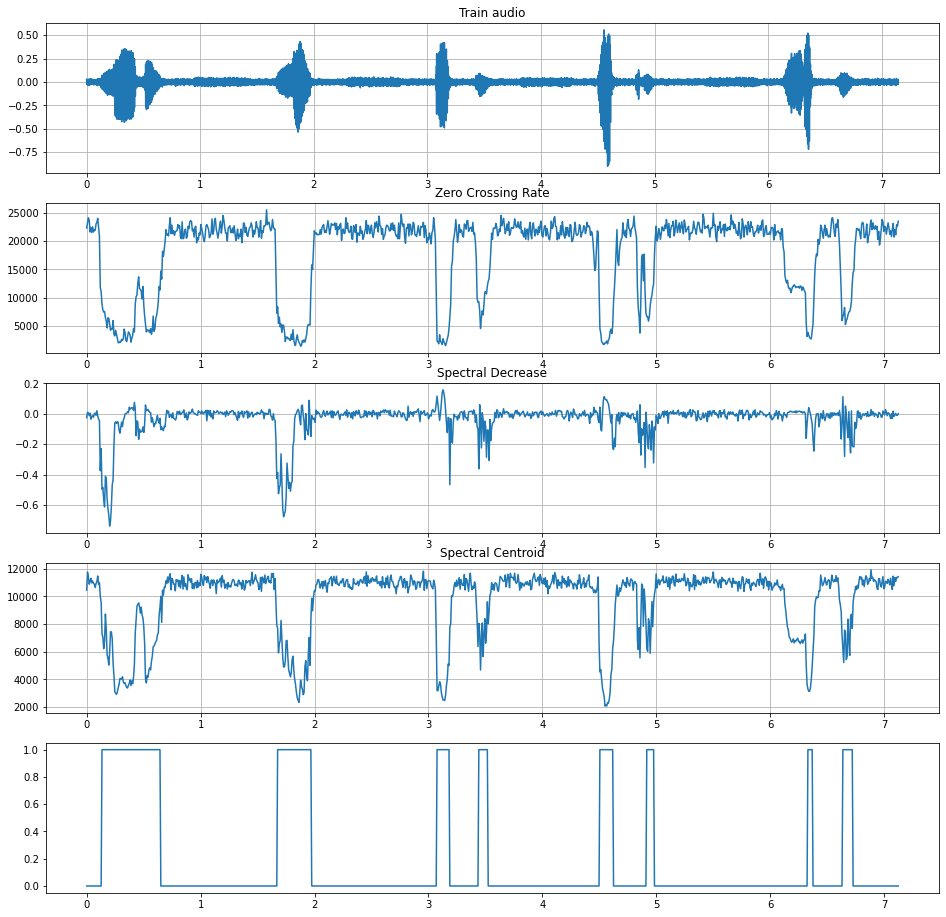

In [10]:
plt.figure(figsize=(16, 16))

plt.subplot(5,1,1)
time_axis = np.arange(audio_train.shape[0]) / Fs
plt.plot(time_axis, audio_train)
plt.grid(True)
plt.title('Train audio')

plt.subplot(5,1,2)
feat_time_axis = np.arange(train_features.shape[0]) * hop_size / Fs
plt.title(features_names[0])
plt.plot(feat_time_axis, train_features[:, 0])
plt.grid(True)

plt.subplot(5,1,3)
feat_time_axis = np.arange(train_features.shape[0]) * hop_size / Fs
plt.title(features_names[1])
plt.plot(feat_time_axis, train_features[:, 1])
plt.grid(True)


plt.subplot(5,1,4)
feat_time_axis = np.arange(train_features.shape[0]) * hop_size / Fs
plt.title(features_names[2])
plt.plot(feat_time_axis, train_features[:, 2])
plt.grid(True)


plt.subplot(5,1,5)
plt.plot(feat_time_axis, train_labels)

plt.show()

### Plot histogram of the selected features values for each class

In [11]:
train_features_0 = train_features[train_labels==0]
train_features_1 = train_features[train_labels==1]
len(train_features_1)

178

Zero Crossing Rate


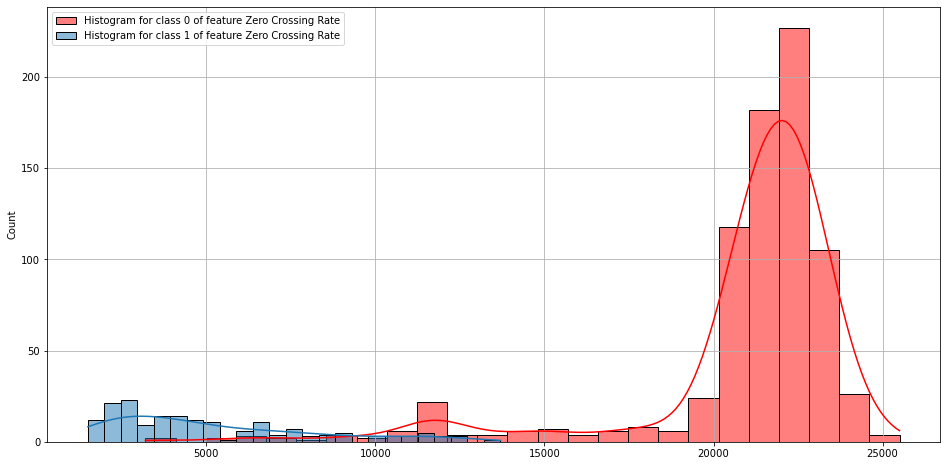

Spectral Decrease


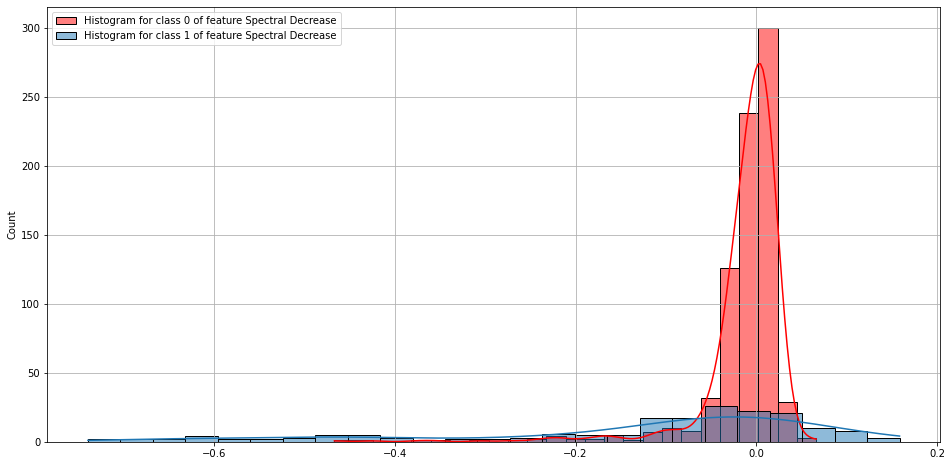

Spectral Centroid


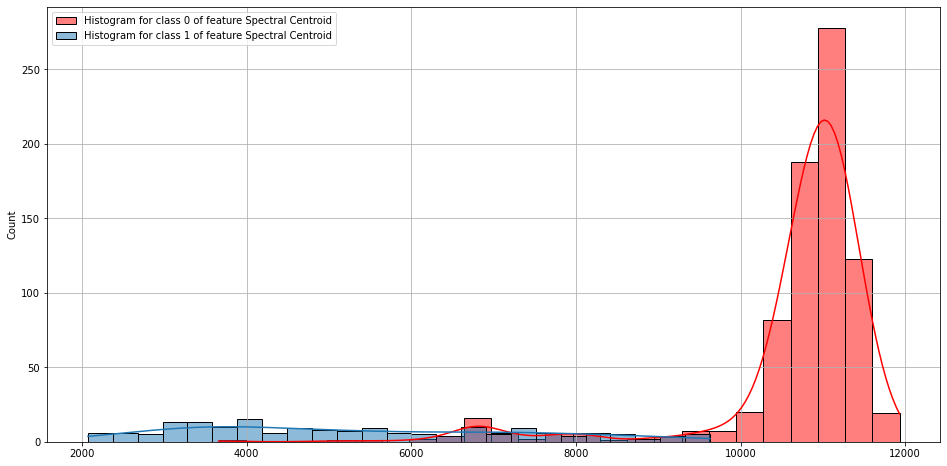

In [12]:
for feat_index, feat in enumerate(features_names):
    plt.figure(figsize=(16, 8))
    print(feat)
    sns.histplot(train_features_0[:, feat_index], label='Histogram for class 0 of feature {}'.format(feat),
                kde=True, color='red', bins=25)
    sns.histplot(train_features_1[:, feat_index], label='Histogram for class 1 of feature {}'.format(feat), 
                 kde=True,  bins=25)
    plt.legend()
    plt.grid(True)
    plt.show()

# Test feature computation

### Load test audio files

In [13]:
test_path = ('Input/test.wav')
audio_test, Fs = librosa.load(test_path, sr=None)

### Compute features for test

In [14]:
test_win_number = int(np.floor((audio_test.shape[0] - win_length) / hop_size))

test_features = np.zeros((test_win_number, n_features))

for i in np.arange(test_win_number):
    frame = audio_test[i * hop_size : i * hop_size + win_length]
    frame_wind = frame * window
    
    spec = np.fft.fft(frame_wind)
    nyquist = int(np.floor(spec.shape[0] / 2))
    spec = spec[1:nyquist]
    
    test_features[i, 0] = compute_zcr(frame_wind, Fs)
    test_features[i, 1] = compute_specdec(spec)
    test_features[i, 2] = compute_speccentr(spec, Fs)


### Load GT labels

In [15]:
test_labels = np.genfromtxt('Input/test_GT.csv', delimiter=' ')

# Naive approach

Let's select just one feature and compute **mean** and **standard deviation** on the train set for each class. With these two estimates we can define two gaussian distributions, one for class 0 and one for class 1.



In [16]:
selected_feature_index = 0


mu0 = np.mean(train_features_0[:, selected_feature_index])
std0 = np.std(train_features_0[:, selected_feature_index])

mu1 = np.mean(train_features_1[:, selected_feature_index])
std1 = np.std(train_features_1[:, selected_feature_index])



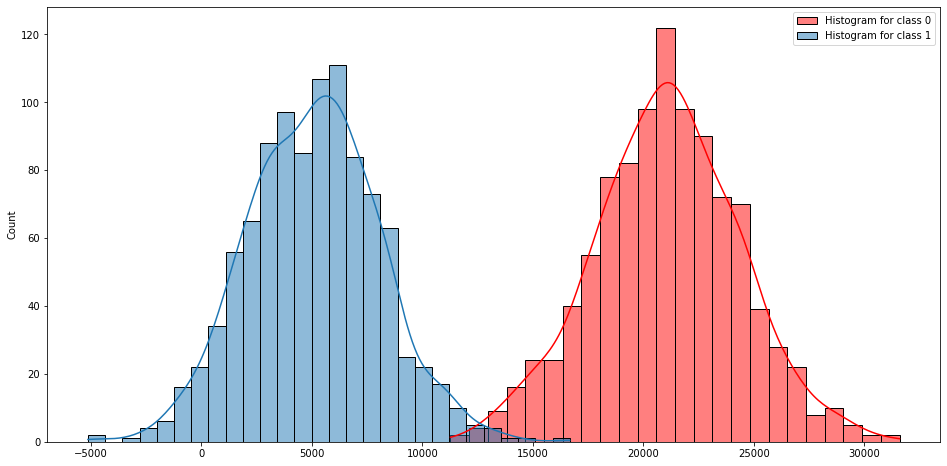

In [17]:
# Create a normal continuous random variable
gauss_0 = scipy.stats.norm(mu0, std0)
gauss_1 = scipy.stats.norm(mu1, std1)

plt.figure(figsize=(16, 8))

# sample 1000 points from the distribution for class 0
r0 = gauss_0.rvs(size=1000)

# plot their distribution
sns.histplot(r0, label='Histogram for class 0', kde=True, color='red');

# sample 1000 points from the distribution for class 1
r1 = gauss_1.rvs(size=1000)

# plot their ditribution
sns.histplot(r1, label='Histogram for class 1', kde=True)
plt.legend()
plt.show()

In [18]:
# For each point in the test feature
pdf_0 = gauss_0.pdf(test_features[:, selected_feature_index].reshape(-1,1))
pdf_1 = gauss_1.pdf(test_features[:, selected_feature_index].reshape(-1,1))
pdf = np.concatenate([pdf_0, pdf_1], axis=1)

naive_predicted_test_labels = np.argmax(pdf, axis=1)


# GMM definition, training and evaluation

### GMM definition

In [19]:
n_components = 3
gmm_0 = BayesianGaussianMixture(n_components=n_components, random_state=2)
gmm_1 = BayesianGaussianMixture(n_components=n_components, random_state=2)

### GMM initializations and training

In [20]:
gmm_0.fit(train_features_0)
gmm_1.fit(train_features_1);

### Predict test labels

In [21]:
mixt_pdf_0 = []
mixt_pdf_1 = []  

sample_0 = []
sample_1 = []

for n in np.arange(n_components):
    
    # Create a normal continuous random variable using the parameters estimated by EM algorithm for each class

    mixt_gauss_0 = scipy.stats.multivariate_normal(gmm_0.means_[n, :], gmm_0.covariances_[n, :], allow_singular=True)
    mixt_gauss_1 = scipy.stats.multivariate_normal(gmm_1.means_[n, :], gmm_1.covariances_[n, :], allow_singular=True)

    sample_0.append(mixt_gauss_0.rvs(np.int(500 * gmm_0.weights_[n])))
    sample_1.append(mixt_gauss_1.rvs(np.int(500 * gmm_1.weights_[n])))
    
    mixt_pdf_0.append(gmm_0.weights_[n] * mixt_gauss_0.pdf(test_features))
    mixt_pdf_1.append(gmm_1.weights_[n] * mixt_gauss_1.pdf(test_features))

pdf_0 = np.sum(mixt_pdf_0, axis=0).reshape(-1,1)
pdf_1 = np.sum(mixt_pdf_1, axis=0).reshape(-1,1)

pdf = np.concatenate((pdf_0, pdf_1), axis=1)

In [22]:
predicted_test_labels = np.argmax(pdf, axis=1)

### Plot samples drawn from the mixtures

In [23]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

markers = ['x', 'o', '*']
for n in np.arange(n_components):
    x = sample_0[n][:, 0]
    y = sample_0[n][:, 1]
    z = sample_0[n][:, 2]
    ax.scatter(x, y, z, c='r', marker=markers[n])
    
    x = sample_1[n][:, 0]
    y = sample_1[n][:, 1]
    z = sample_1[n][:, 2]
    ax.scatter(x, y, z, c='b', marker=markers[n])


plt.show()

Using matplotlib backend: Qt5Agg


### *Exercise 4* : Define metrics

Write a function that takes as input the ground truth labels, the predicted labels and compute **precision**, **recall**, **accuracy** and **F1 score**. Once computed, print the results and return.


In [24]:
def compute_metrics(gt_labels, predicted_labels):
    TP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 1))
    FP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 0))
    TN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 0))
    FN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 1))
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)
    print("Results : \n accuracy = {} \n precision = {} \n recall = {} \n F1 score = {}".format(
        accuracy, precision, recall, F1_score))
    

In [25]:
compute_metrics(test_labels, predicted_test_labels)

Results : 
 accuracy = 0.9603567888999008 
 precision = 0.8657407407407407 
 recall = 0.9444444444444444 
 F1 score = 0.9033816425120773


In [26]:
compute_metrics(test_labels, naive_predicted_test_labels)

Results : 
 accuracy = 0.933597621407334 
 precision = 0.758893280632411 
 recall = 0.9696969696969697 
 F1 score = 0.8514412416851441
